# IBM Advanced Data Science Capstone
The object of this project is to use a solid data foundation of used cars to predict the expected sales price based on factors such as brand, model, mileage and so on.
## Initial Data Exploration
This project uses the *Used Cars Dataset* from [Kaggle](https://www.kaggle.com/austinreese/craigslist-carstrucks-data), which is a continuous webscraping of Craigslist every few months for used cars for sale in the United States. At this writing, the dataset contains 435.849 entries with 25 columns:

| Column | Description |
| :- | :- |
| `id` | Unique Craigslist identifier |
| `url` | Direct link to the Craigslist posting |
| `region` | Text field indicating location of vehicle |
| `region_url` | URL to local Craigslist site |
| `price` | Poster's desired price in USD |
| `year` | Registration year |
| `manufacturer` | Car brand (ie. Volkswagen, Ford, etc.) |
| `model` | Car model (ie. Passat, Fiesta, etc.) |
| `condition` | Condition of the vehicle |
| `cylinders` | How many cylinders in engine |
| `fuel` | Type of fuel (ie. gas, diesel, electric) |
| `odometer` | Mileage on the vehicle |
| `title_status` | Title status of vehicle |
| `transmission` | Transmission of vehicle (manual vs automatic) |
| `vin` | Unique VIN (Vehicle Identification Number) |
| `drive` | Drivetrain |
| `size` | Vehicle size class |
| `type` | Eg. SUV, hatchback, sedan, etc. |
| `paint_color` | Color of the vehicle |
| `image_url` | URL to image associated with the ad |
| `description` | Free text field with description of the vehicle |
| `county` | County where the vehicle is located |
| `state` | State where the vehicle is located |
| `lat` / `long` | Latitude and longitude of vehicle location |

### Data Load
I use the Kaggle interface to download the data:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import seaborn as sns
import os
os.environ['comspec'] = 'powershell.exe'
os.getenv('conspec')

In [2]:
!kaggle datasets download -d austinreese/craigslist-carstrucks-data

!Expand-Archive craigslist-carstrucks-data.zip -DestinationPath data/
!Remove-Item -path craigslist-carstrucks-data.zip -recurse
!ls

In [3]:
data = pd.read_csv('data/vehicles.csv', index_col='id')

### Exploratory Data Analysis
We'll first have a very high level overview of the data at hand.

In [4]:
def print_details(data):
    nums =  data.select_dtypes(exclude="object").columns.values
    cats =  data.select_dtypes(include="object").columns.values
    print(
        f'Number of numerical features: {len(nums)}',
        'Null count:\n' + 40*'-',
        ((data[nums].isnull().sum() / len(data) * 100).sort_values(ascending=False)),
        f'\nNumber of categorical features: {len(cats)}',
        ((data[cats].isnull().sum() / len(data) * 100).sort_values(ascending=False)),
        f'Total number of observations: {data.shape[0]}',
        sep='\n'
    )

In [5]:
print_details(data)

Number of numerical features: 6
Null count:
----------------------------------------
county      100.000000
odometer     36.161252
long         23.463810
lat          23.463810
year         22.440115
price         0.000000
dtype: float64

Number of categorical features: 18
size            75.787353
condition       58.306929
vin             56.490043
cylinders       53.361865
paint_color     47.575951
drive           45.472412
type            43.104160
manufacturer    26.097245
model           23.232600
fuel            22.800850
title_status    22.672269
transmission    22.600075
description     22.225184
image_url       22.223533
region           0.000000
state            0.000000
region_url       0.000000
url              0.000000
dtype: float64
Total number of observations: 423857


From initial observations, we have a lot of data containing missing values. The `county` column is entirely blank, while over 75% of `size` is missing. There are a variety of ways to handle missing data, but as a rule of thumb, when more than 60-70% of the data is missing, the variable should be dropped. Since size can be roughly derived from the make and model combination, we'll leave that in for now. As for `county`, it is purposeless, so we'll drop it. Having also sampled some of the url features, one can arrive at the same conclusion. We'll drop those as well. Looking at the other end of the spectrum, the `manufacturer` column is 26% missing. We could try and fill the blanks with the most frequent of occurrences in this column, but it's safe to say, that without this information, a proper price estimation wouldn't (and shouldn't) be possible. We'll consequently drop all rows where `manufacturer` (and `model` for good measure) is missing.

In [6]:
data = data.drop(['county', 'image_url', 'region_url', 'url'], axis=1)
data = data.dropna(subset=['manufacturer', 'model'])

In [7]:
data.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,description,state,lat,long
id,,,,,,,,,,,,,,,,,,,,
7184791621,duluth / superior,6995,2000.0,gmc,new sierra 1500,excellent,8 cylinders,gas,167783.0,clean,automatic,1GTEK19T3YE366021,4wd,NaN,NaN,red,2000 *** GMC New Sierra 1500 Ext Cab 157.5 WB...,mn,46.8433,-92.2550
7184773187,duluth / superior,8750,2013.0,hyundai,sonata,excellent,4 cylinders,gas,90821.0,clean,automatic,NaN,fwd,NaN,NaN,grey,For Sale: 2013 Hyundai Sonata GLS - $8750. O...,mn,46.9074,-92.4638
7193375964,new haven,10900,2013.0,toyota,prius,good,4 cylinders,hybrid,92800.0,clean,automatic,NaN,fwd,NaN,NaN,blue,2013 Prius V Model Two. One owner—must sell my...,ct,41.1770,-73.1336
7195108810,albuquerque,12500,2003.0,mitsubishi,lancer,good,4 cylinders,gas,NaN,clean,manual,NaN,4wd,mid-size,sedan,grey,"2003 Mitsubishi Lancer Evolution, silver. Abo...",nm,35.1868,-106.6650
7184712241,duluth / superior,16995,2007.0,gmc,sierra classic 2500hd,good,8 cylinders,diesel,254217.0,clean,automatic,1GTHK23D57F102022,4wd,full-size,truck,white,"**Bad Credit, No Credit... No Problem!**2007 G...",mn,45.6836,-92.9648


Let's look at some visualizations.

### Numerical Features
#### Price

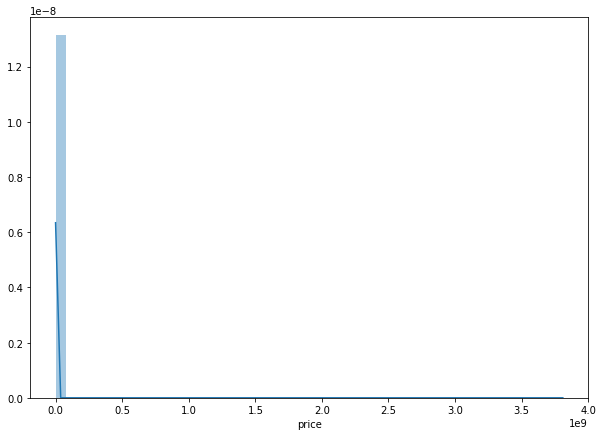

In [8]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.distplot(data['price'], ax=ax)
plt.show()

Looking at the above distribution plot of the `price` column, we see that there is a very high concentration at around 0, while some vehicles have unrealistically high prices close to \$4 billion. For fun, let's have a look at this specific model.

In [9]:
data[data['price'] == data['price'].max()]

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,description,state,lat,long
id,,,,,,,,,,,,,,,,,,,,
7193668004,flint,3808256046,2007.0,saturn,aura,good,NaN,gas,NaN,clean,automatic,NaN,NaN,NaN,NaN,red,"2007 Saturn Aura has 140,224 miles on it. Grea...",mi,42.9821,-83.734


Now, a Saturn Aura does look like a nice car but it is hardly worth \$3.8 billion. There are several ways of detecting outliers in a dataset. One such way is calculating the standard score $Z$ of each data point. The $Z$-score is defined as the number of standard deviations above or below the mean of a distribution a measure is. Or
$$Z = \frac{x - \mu}{\sigma}$$
where $\mu$ and $\sigma$ are the mean and standard deviation of the distribution, respectively. Picking the right threshold of the $Z$-score can be tricky, and playing around with different values, we arrive at $Z = 0.005$.

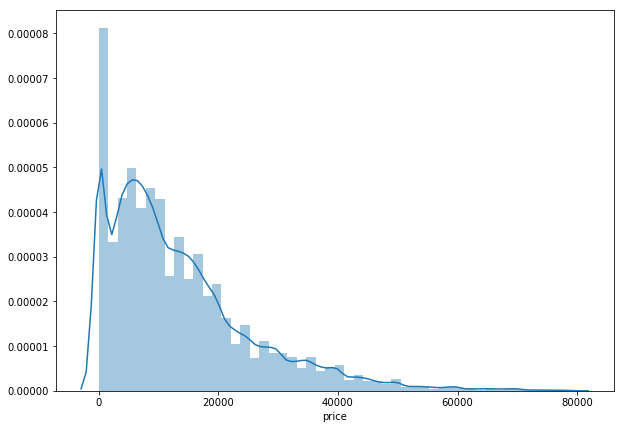

In [10]:
from scipy.stats import zscore
z = zscore(data['price'])

fig, ax = plt.subplots(figsize=(10, 7))
sns.distplot(data.iloc[np.abs(z) < 0.005]['price'], ax=ax)
plt.show()

In [11]:
data = data.iloc[np.abs(z) < 0.005]
data.describe()

,price,year,odometer,lat,long
count,308315.000000,308304.000000,2.570980e+05,303439.000000,303439.000000
mean,13560.227462,2010.371302,9.879591e+04,38.784463,-94.010960
std,12263.187575,9.034856,1.092987e+05,5.899252,17.937633
min,0.000000,1911.000000,0.000000e+00,-80.386400,-161.394000
25%,4795.000000,2007.000000,4.505900e+04,35.087300,-106.682000
50%,10000.000000,2012.000000,9.201100e+04,39.389100,-88.039500
75%,18990.000000,2016.000000,1.371450e+05,42.598200,-80.985850
max,78900.000000,2021.000000,1.000000e+07,80.383400,115.524000


There are also vehicle priced at \$0. Let's set a lower threshold of \$2000.

In [12]:
data = data[data['price'] >= 2000]
data.describe()

,price,year,odometer,lat,long
count,265866.000000,265855.000000,2.261230e+05,264114.000000,264114.00000
mean,15669.512687,2010.307596,9.916456e+04,38.826539,-93.80658
std,11917.514833,9.171975,1.081257e+05,5.945867,17.77061
min,2000.000000,1911.000000,0.000000e+00,-80.386400,-161.39400
25%,6975.000000,2007.000000,4.621050e+04,35.119200,-106.49800
50%,12500.000000,2012.000000,9.300000e+04,39.462150,-87.90650
75%,20495.000000,2016.000000,1.374955e+05,42.598200,-81.00790
max,78900.000000,2021.000000,9.999999e+06,80.383400,115.52400


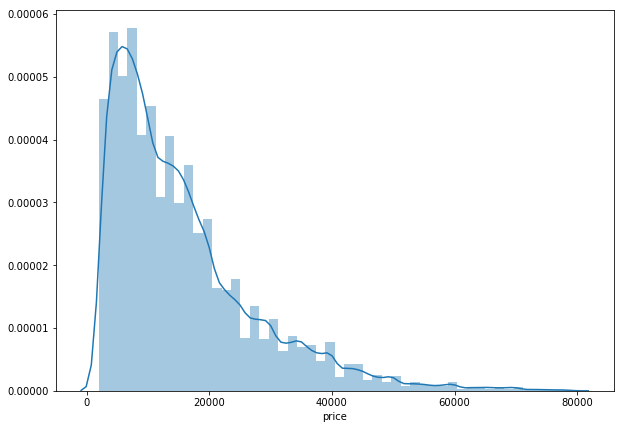

In [13]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.distplot(data['price'], ax=ax)
plt.show()

#### Year
The `year` column indicates registration year of the vehicle. We would expect the average value of a vehicle to decrease (and the mileage increase) over the years. This column should therefore have a lot of importance when evaluating a car.

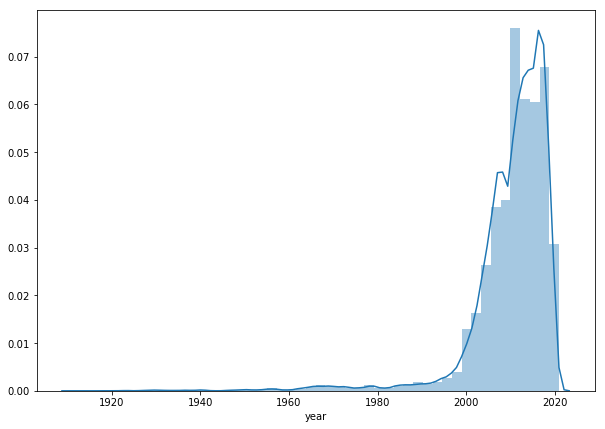

In [14]:
plt.subplots(figsize=(10, 7))
sns.distplot(data['year'])
plt.show()

As with `price`, the `year` column is a skewed distribution. When dealing with a skewed distribution such as this, the machine learning model, when trained, will learn on a much higher number of new vehicles, and will be less likely to predict the price of older cars. One way of dealing with this skewness would be to simply exclude all data from before the year 2000. But we want our model to be able to predict the value of a car irregardless of what year it's from. So we turn to power transformations instead. A power transformation is a function that, when applied to a data distribution, tries to stabilize the variance, conforming the data closer to a normal distribution. A popular choice is the Box-Cox Transformation (for strictly positive data; an expansion of Box-Cox is the Yeo-Johnson transform). It transforms the data by some scalar $\lambda$:

$${\displaystyle y_{i}^{(\lambda )}={\begin{cases}{\dfrac {y_{i}^{\lambda }-1}{\lambda }}&{\text{if }}\lambda \neq 0,\\\ln y_{i}&{\text{if }}\lambda =0\end{cases}}}$$

Finding the right $\lambda$ can be tricky. Luckily the scikit-learn package has a built in function that finds the best value for us:

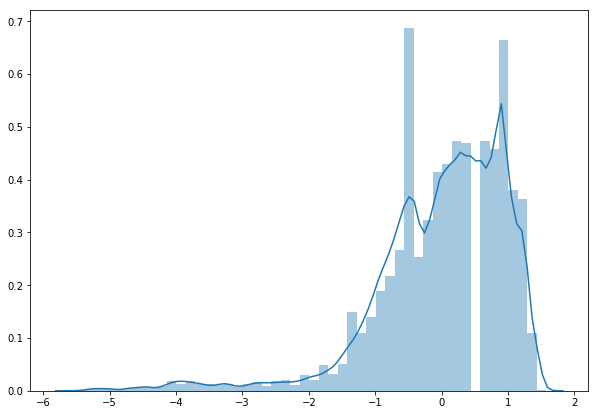

In [15]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
pt.fit(data[['year']])

plt.figure(figsize=(10, 7))
sns.distplot(pt.transform(data[['year']]))
plt.show()

#### Odometer
We'll consider the information in `odometer` to be of same value as the `year` column. From below, we see the data to be heavily right skewed.

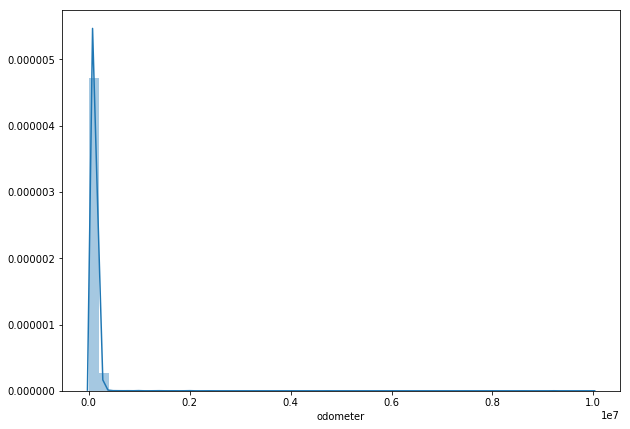

In [16]:
plt.subplots(figsize=(10, 7))
sns.distplot(data['odometer'])
plt.show()

Applying the power transform, we are able to make the data more like a normal distribution.

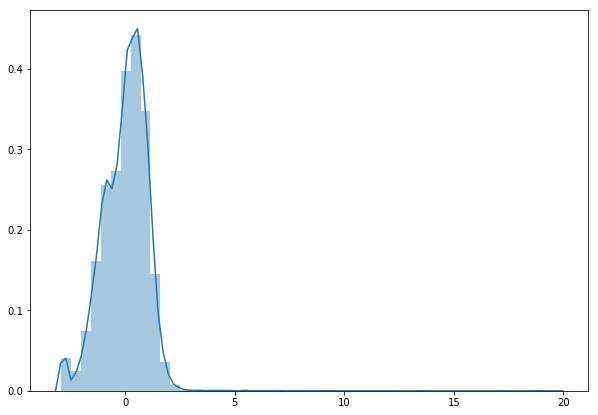

In [17]:
pt = PowerTransformer(method='yeo-johnson')
pt.fit(data[['odometer']])

plt.figure(figsize=(10, 7))
sns.distplot(pt.transform(data[['odometer']]))
plt.show()

#### Latitude and longitude
Along with `state`, the latitude and longitude columns gives information as to where on earth (or the US to be more precise) is the car for sale? We'll take a small sample of the data and plot them on a map.

In [21]:
import plotly.graph_objects as go
import plotly.express as px

fig = px.scatter_mapbox(
    data.sample(n=5000),
    lat='lat',
    lon='long',
    color='state',
    zoom=2.8,
    height=600,
    width=800
)
fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(margin={'t':0, 'l':0, 'b':0})
fig.show()

From the map above, the majority of the vehicles are located in the eastern part of the US.

### Categorical Features
Let's have a look at the categorical features. For now, let's ignore `vin`, `description`, `state`, and `model`.

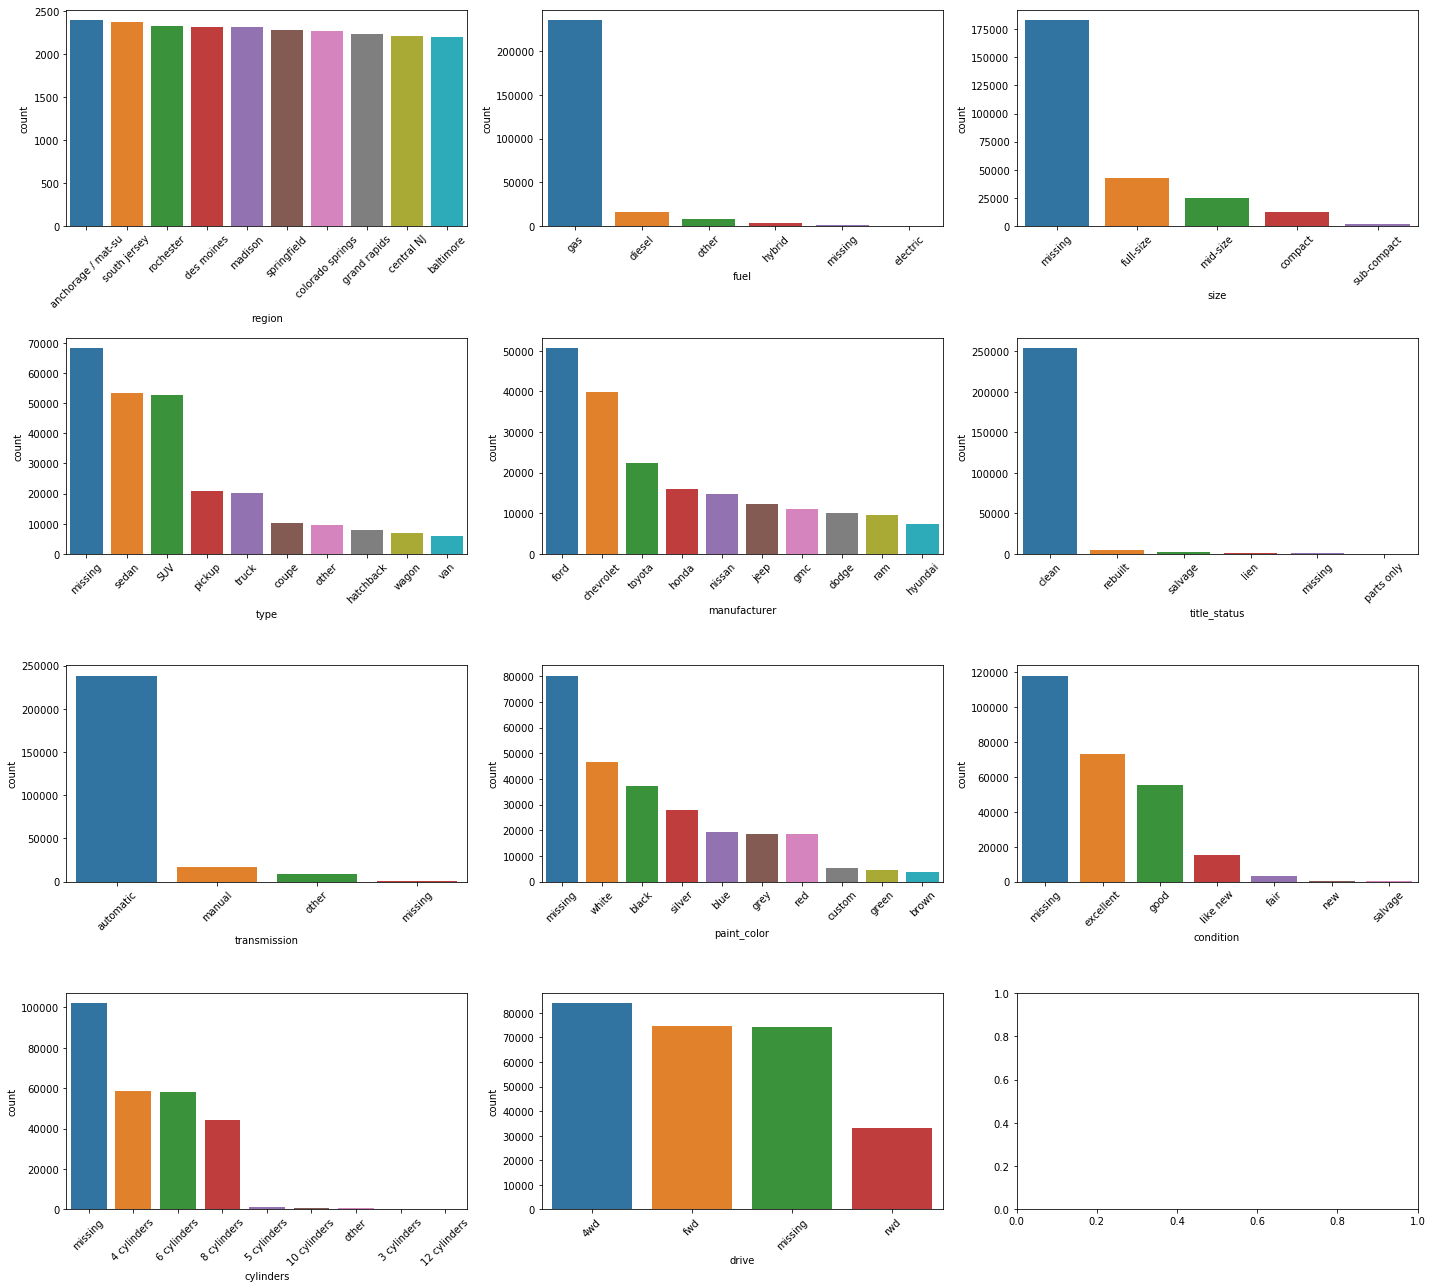

In [22]:
cats = [
    'region', 'manufacturer', 'condition',
    'cylinders', 'fuel', 'title_status', 
    'transmission', 'drive', 'size', 
    'type', 'paint_color'
]
data_cats = data[cats + ['price']].fillna('missing')
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(20, 18))
for i, c in enumerate(cats):
    value_counts = data_cats[c].value_counts()
    value_counts = value_counts if len(value_counts) < 10 else value_counts[:10]
    data_c = data_cats[data_cats[c].isin(value_counts.index.values)]
    plot = sns.countplot(x=c, data=data_c, ax=ax[i%4, i%3], order=value_counts.index)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

From the above plots, we can see that the data is somewhat imbalanced on a variety of columns. This can be a problem (though not necessarily), as the model would then attribute some features with higher significance than they actually have. Ways of handling this would be to either undersample (select fewer observations from the majority class), oversample (replicate underrepresented classes) or generate synthetic data by using SMOTE (Synthetic Minority Oversampling Technique) for regression (eg. [smogn](https://github.com/nickkunz/smogn)). For now, we'll leave them as is.

In [23]:
data.to_parquet('data/vehicles.parquet.gzip', compression='gzip', index=True)